In [1]:
from typing import List, Optional, Tuple, Any

import hydra
import pyrootutils
import pytorch_lightning as pl
from omegaconf import DictConfig
from pytorch_lightning import Callback, LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers import Logger

import shutil
import zipfile
import gdown
import os 
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Subset
import torch
from torchvision.datasets import FashionMNIST

import albumentations as A
from albumentations import Compose
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.nn import Module


In [3]:
class KvasirDataset(Dataset):
    def __init__(
        self,
        data_dir: str = "data",
    ) -> None:
        super().__init__()
        
        self.data_dir = data_dir
        
        self.prepare_data()
        
        image_folder_dir = os.path.join(self.data_dir, "kvasir-seg/Kvasir-SEG/images") 
        mask_folder_dir = image_folder_dir.replace("images", "masks")

        self.image_path_list = []
        self.masks_path_list = []
                
        # Read all the image paths
        for file in os.listdir(image_folder_dir):
            if file.endswith(".jpg"):
                image_path = os.path.join(image_folder_dir, file)
                self.image_path_list.append(image_path)
                
                mask_path = image_path.replace("images", "masks")
                self.masks_path_list.append(mask_path)
        
    def __len__(self):
        return len(self.image_path_list)
    
    def __getitem__(self, index):
        image = np.array(Image.open(self.image_path_list[index]).convert("RGB"))
        mask = Image.open(self.masks_path_list[index])
        mask = self.grayscale_mask(mask)
        
        return np.array(image, dtype=np.uint8), mask
    
    def prepare_data(self):
        data_path = os.path.join(self.data_dir, "kvasir-seg")
        if os.path.exists(data_path):
            print("Data is downloaded")
            return
        
        file_id = "1VQrfSqG2HPy5y1FykcsrE0x1d6iyxENC"
        output = "kvasir-seg.zip"
        print("Downloading data")
        
        gdown.download(id=file_id, output=output, quiet=False)

        os.makedirs(data_path, exist_ok=True)

        shutil.move("./kvasir-seg.zip", data_path)

        downloaded_file = os.path.join(data_path, "kvasir-seg.zip")

        print("Extracting ...")
        with zipfile.ZipFile(downloaded_file, "r") as zip_ref:
            zip_ref.extractall(data_path)

        print("Removing unnecessary file")
        os.remove(downloaded_file)

        print("Done")
        
    def grayscale_mask(self, mask):
        mask_gray = mask.convert('L')

        mask_gray_np = np.array(mask_gray)

        # Threshold
        threshold = 10  
        mask_gray_img = np.where(mask_gray_np > threshold, 1, 0).astype(np.uint8)
        
        return mask_gray_img

Data is downloaded


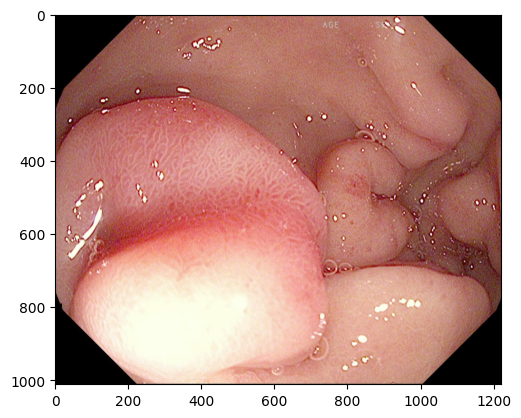

In [4]:
kvasir_dataset = KvasirDataset()
image, mask = kvasir_dataset[100]
plt.imshow(image)

In [5]:
class Transform_KvasirSEGDataset(Dataset):
    mean = None
    std = None

    def __init__(self, dataset: KvasirDataset, transform: Optional[Compose] = None) -> None:
        super().__init__()

        self.dataset = dataset

        if transform is not None:
            self.transform = transform
        else:
            self.transform = Compose(
                [
                    A.Resize(256, 256),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2(),
                ]
            )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index) -> Any:
        image, mask = self.dataset[index]  # (768, 768, 3), (768, 768)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            # img_size set in hydra config
            image = transformed["image"]  # (3, img_size, img_size)
            mask = transformed["mask"]  # (img_size, img_size), uint8
            mask = mask.unsqueeze(0).float()  # (1, img_size, img_size)

        return image, mask

In [6]:
kvasir = Transform_KvasirSEGDataset(KvasirDataset())
image, mask = kvasir[100]

Data is downloaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


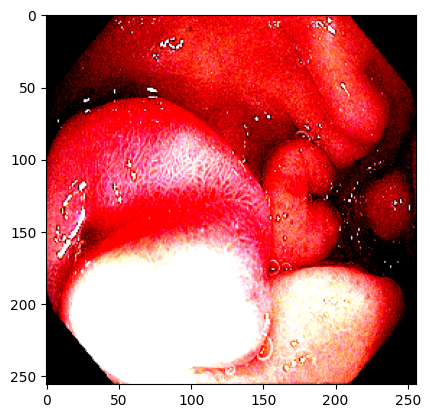

In [7]:
plt.imshow(image.permute(1, 2, 0))

In [8]:
print("Shape:", image.shape)
print("Max:", image.max())
print("Min:", image.min())

Shape: torch.Size([3, 256, 256])
Max: tensor(2.6400)
Min: tensor(-2.1179)


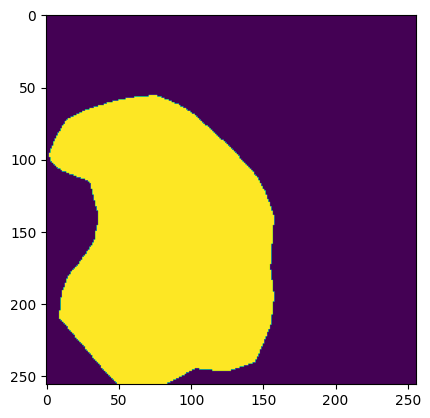

In [9]:
plt.imshow(mask.permute(1, 2, 0) * 255)

In [10]:

class KvasirSEGDataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str = "data",
        train_val_test_split: Tuple[int, int, int] = (0.8, 0.1, 0.1),
        transform_train: Optional[A.Compose] = None,
        transform_val: Optional[A.Compose] = None,
        batch_size: int = 4,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        self.data_train: Optional[Dataset] = None
        self.data_val: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None

    def setup(self, visualize_dist=False, stage: Optional[str] = None):
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.

        This method is called by lightning with both `trainer.fit()` and `trainer.test()`, so be
        careful not to execute things like random split twice!
        """
        # load and split datasets only if not loaded already
        if not self.data_train and not self.data_val and not self.data_test:
            dataset = KvasirDataset(
                data_dir=self.hparams.data_dir,
            )
            data_len = len(dataset)
            train_len = int(data_len * self.hparams.train_val_test_split[0])
            val_len = int(data_len * self.hparams.train_val_test_split[1])
            test_len = data_len - train_len - val_len

            self.data_train, self.data_val, self.data_test = random_split(
                dataset=dataset,
                lengths=[train_len, val_len, test_len],
                generator=torch.Generator().manual_seed(42),
            )

            # create transform dataset from subset
            self.data_train = Transform_KvasirSEGDataset(self.data_train, self.hparams.transform_train)
            self.data_val = Transform_KvasirSEGDataset(self.data_val, self.hparams.transform_val)
            self.data_test = Transform_KvasirSEGDataset(self.data_test, self.hparams.transform_val)
            
            print(len(self.data_train), len(self.data_val), len(self.data_test))


    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

In [11]:
class UNet_down_block(Module):
    def __init__(self, input_channel, output_channel, down_size):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet_up_block(Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super().__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode="bilinear")
        self.conv1 = torch.nn.Conv2d(
            prev_channel + input_channel, output_channel, 3, padding=1
        )
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.down_block1 = UNet_down_block(3, 16, False)
        self.down_block2 = UNet_down_block(16, 32, True)
        self.down_block3 = UNet_down_block(32, 64, True)
        self.down_block4 = UNet_down_block(64, 128, True)
        self.down_block5 = UNet_down_block(128, 256, True)
        self.down_block6 = UNet_down_block(256, 512, True)
        self.down_block7 = UNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)
        self.up_block5 = UNet_up_block(32, 64, 32)
        self.up_block6 = UNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x

In [13]:
import gc

from torchmetrics import Dice, JaccardIndex, MaxMetric, MeanMetric
from src.models.loss_function.lossbinary import LossBinary
from src.models.loss_function.lovasz_loss import BCE_Lovasz

class UNetLitModule(LightningModule):
    def __init__(
        self,
        net: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        criterion: torch.nn.Module,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False, ignore=["net", "criterion"])

        self.net = net

        # loss function
        self.criterion = criterion

        # metric objects for calculating and averaging accuracy across batches
        self.train_metric_1 = JaccardIndex(task="binary", num_classes=2)
        self.val_metric_1 = JaccardIndex(task="binary", num_classes=2)
        self.test_metric_1 = JaccardIndex(task="binary", num_classes=2)

        self.train_metric_2 = Dice()
        self.val_metric_2 = Dice()
        self.test_metric_2 = Dice()

        # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for tracking best so far validation accuracy
        self.val_metric_best_1 = MaxMetric()
        self.val_metric_best_2 = MaxMetric()

    def forward(self, x: torch.Tensor):
        return self.net(x)

    def on_train_start(self):
        # by default lightning executes validation step sanity checks before training starts,
        # so it's worth to make sure validation metrics don't store results from these checks
        self.val_loss.reset()
        self.val_metric_1.reset()
        self.val_metric_2.reset()
        self.val_metric_best_1.reset()
        self.val_metric_best_2.reset()

    def model_step(self, batch: Any):
        x, y = batch

        if isinstance(self.criterion, (LossBinary, BCE_Lovasz)):
            cnt1 = (y == 1).sum().item()  # count number of class 1 in image
            cnt0 = y.numel() - cnt1
            if cnt1 != 0:
                BCE_pos_weight = torch.FloatTensor([1.0 * cnt0 / cnt1]).to(device=self.device)
            else:
                BCE_pos_weight = torch.FloatTensor([1.0]).to(device=self.device)

            self.criterion.update_pos_weight(pos_weight=BCE_pos_weight)

        preds = self.forward(x)
        loss = self.criterion(preds, y)

        # Code to try to fix CUDA out of memory issues
        del x
        gc.collect()
        torch.cuda.empty_cache()

        return loss, preds, y

    def training_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.model_step(batch)

        # update and log metrics
        self.train_loss(loss)
        self.train_metric_1(preds, targets)
        self.train_metric_2(preds, targets.int())

        self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/jaccard", self.train_metric_1, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/dice", self.train_metric_2, on_step=False, on_epoch=True, prog_bar=True)

        # we can return here dict with any tensors
        # and then read it in some callback or in `training_epoch_end()` below
        # remember to always return loss from `training_step()` or backpropagation will fail!
        return {"loss": loss}

    def validation_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.model_step(batch)

        # update and log metrics
        self.val_loss(loss)
        self.val_metric_1(preds, targets)
        self.val_metric_2(preds, targets.int())

        self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(
            "val/jaccard",
            self.val_metric_1,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "val/dice",
            self.val_metric_2,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )

        return {"loss": loss, "preds": preds, "targets": targets}

    def validation_epoch_end(self, outputs: List[Any]):
        # get current val acc
        acc1 = self.val_metric_1.compute()
        acc2 = self.val_metric_2.compute()
        # update best so far val acc
        self.val_metric_best_1(acc1)
        self.val_metric_best_2(acc2)
        # log `val_acc_best` as a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log("val/jaccard_best", self.val_metric_best_1.compute(), prog_bar=True)
        self.log("val/dice_best", self.val_metric_best_2.compute(), prog_bar=True)

    def test_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.model_step(batch)

        # update and log metrics
        # update and log metrics
        self.test_loss(loss)
        self.test_metric_1(preds, targets)
        self.test_metric_2(preds, targets.int())

        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/jaccard", self.test_metric_1, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/dice", self.test_metric_2, on_step=False, on_epoch=True, prog_bar=True)

        return {"loss": loss, "preds": preds, "targets": targets}

    def configure_optimizers(self):
        optimizer = self.hparams.optimizer(params=self.parameters())
        if self.hparams.scheduler is not None:
            scheduler = self.hparams.scheduler(optimizer=optimizer)
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val/loss",
                    "interval": "epoch",
                    "frequency": 1,
                },
            }
        return {"optimizer": optimizer}
